In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
from typing import NamedTuple
from collections import namedtuple
%matplotlib inline

In [2]:
time_int = 60
periods = 100
multi_periods = [25, 50, 100]
multiplier = 20
threshold = 1
bankroll = 15000
smooth = int(np.ceil(periods/4))
atr_periods = 80
vol_lookback = 50

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
#contract = contract.loc['20180202':]
contract = contract.loc['20181001':'20181231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180430']
#contract = contract.loc['20190101': '20190410']

In [4]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

28585.278053069054

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-10-01 09:15:00,7672.00,7713.50,7670.75,7704.25,17168,28550,42.750000
1,2018-10-01 14:33:00,7704.25,7719.75,7699.50,7699.75,15155,28410,31.359375
2,2018-10-01 15:35:00,7699.50,7717.25,7691.25,7716.25,14651,28281,29.528071
3,2018-10-01 15:59:00,7716.50,7725.50,7710.00,7719.75,16120,30590,25.888458
4,2018-10-01 16:32:00,7719.75,7728.75,7712.50,7725.50,16046,30132,23.863193
...,...,...,...,...,...,...,...,...
1416,2018-12-31 20:21:00,6350.00,6362.50,6311.50,6327.00,18085,27568,50.861911
1417,2018-12-31 21:14:00,6326.50,6338.25,6297.50,6315.50,19785,30075,50.612234
1418,2018-12-31 21:53:00,6315.00,6333.25,6303.75,6305.25,16057,28914,50.090944


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
data['mid'] = data['close'].rolling(vol_lookback).mean()
data['std'] = data['close'].rolling(vol_lookback).std()
data['upper'] = data['mid'] + 2*data['std']
data['lower'] = data['mid'] - 2*data['std']
data['outliers_up'] = (data['close'] > data['upper']).shift()  * data['close']
data['outliers_down'] = (data['close'] < data['lower']).shift() * data['close']
data['outliers_up'] = data['outliers_up'].replace(0, np.nan)
data['outliers_down'] = data['outliers_down'].replace(0, np.nan)
data

,date,open,close,mid,std,upper,lower,outliers_up,outliers_down
label,,,,,,,,,
0,2018-10-01 09:15:00,7672.00,7704.25,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-10-01 14:33:00,7704.25,7699.75,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-10-01 15:35:00,7699.50,7716.25,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-10-01 15:59:00,7716.50,7719.75,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-10-01 16:32:00,7719.75,7725.50,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1416,2018-12-31 20:21:00,6350.00,6327.00,6259.460,92.625237,6444.710475,6074.209525,NaN,NaN
1417,2018-12-31 21:14:00,6326.50,6315.50,6262.020,92.364280,6446.748561,6077.291439,NaN,NaN
1418,2018-12-31 21:53:00,6315.00,6305.25,6264.495,91.819025,6448.133050,6080.856950,NaN,NaN


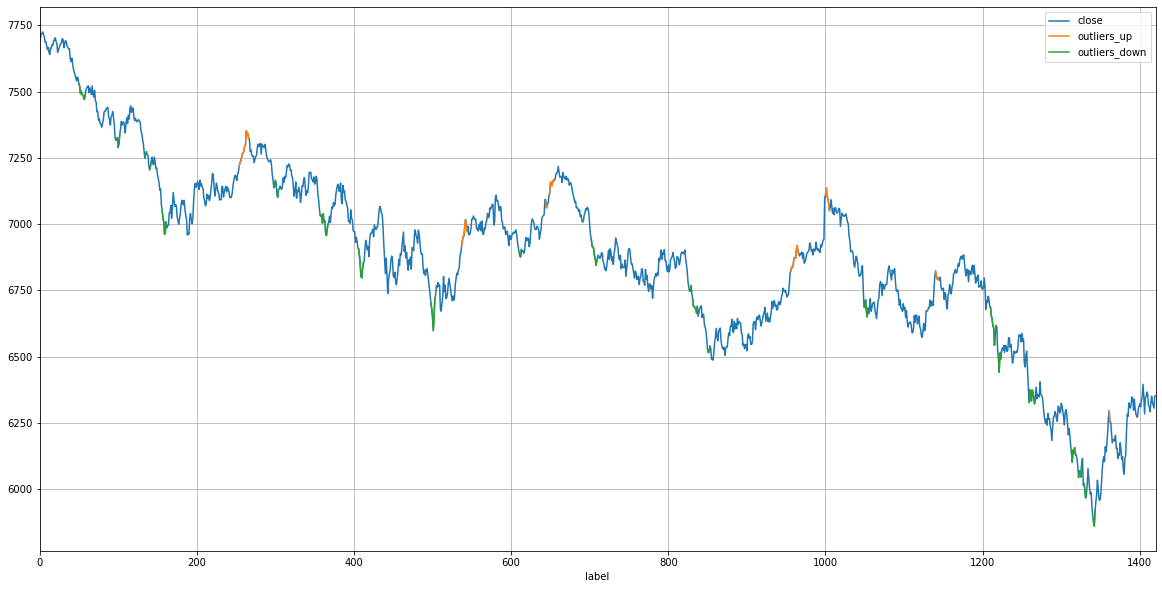

In [8]:
data[['close', 'outliers_up', 'outliers_down']].plot(figsize=(20,10), grid=True);